Baby's First Reinforcement Learning
----------------------------------------------------

In this notebook we will begin to explore the fundamentals of reinforcement learning. From Wikipedia:

**Reinforcement learning (RL)** is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. (see: https://en.wikipedia.org/wiki/Reinforcement_learning)

Reinforcement learning has seen numerous successes in recent years. Groups such as OpenAI and
Google Deepmind have successfully trained agents to play Atari games 1 with super-human skill. More recently,
groups have trained agents to play considerably more complex games like Dota II. In each of these cases, the AI
agent is trained by allowing it to explore the environment, and discovering on it’s own which sequences of
actions lead to maximization of the chosen reward.

We will begin by exploring an old idea known as a **Markov Decision Process** (MDP). MDP's can be applied in reinforcement learning contexts, but as we will see they have limitations. If time allows, we will also explore **Deep Reinforcement Learning** which is a collection of newer techniques designed to overcome the limitations of MDP's by using **Neural Networks**.

In [1]:
from importlib import reload #allow us to reload custom modules any time we like with modifications
from IPython.display import clear_output #so we can iteratively update the output without filling the screen
from collections import deque #fast queue implementation
from pprint import pprint
import matplotlib.pyplot as plt
import time
import environment #custom module
import markov_decision_process #custom module
import progress_bar #custom module
reload(environment)
reload(markov_decision_process)
reload(progress_bar)

#Step 1: Set up the environment such that we can view it, modify it, determine rewards
env = environment.Environment()
print("This is what our environment looks like. The Agent 'A' needs to learn to seek out the food/reward 'R'.")
env.render()

This is what our environment looks like. The Agent 'A' needs to learn to seek out the food/reward 'R'.
----------
|R       |  
|        |  
|        |  
|        |  
|    A   |  
|        |  
|        |  
|        |  
----------


In [48]:
#Step 2: Initialize trainable MDP
mdp = markov_decision_process.MarkovDecisionProcess()
mdp.set_possible_actions(env.agent.get_possible_movement_directions())

#Define the observe->action step functionality we use during training
def train_step(env, mdp, epsilon=0.5):
    #Observe the environment (get the current state).
    state = env.get_state_vector(as_string=True) #String is easier for our MDP class to store
    
    #Given the state, select an action.
    action = mdp.get_predicted_action(state, epsilon)
    env.agent.move(action)
    
    #Determine if we got a reward. 
    reward = 0
    if env.has_agent_food_collision():
        reward = 1
        env.reset_food()
        
    return state, action, reward #This will be used by the outer training loop to encourage rewarding actions

#Observe that prior to training the MDP, our agent moves around essentially randomly
for i in range(0,10):
    train_step(env, mdp)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|     R  |  
|        |  
|        |  
|        |  
|  A     |  
|        |  
|        |  
|        |  
----------


Progress: [####################] 100.0%


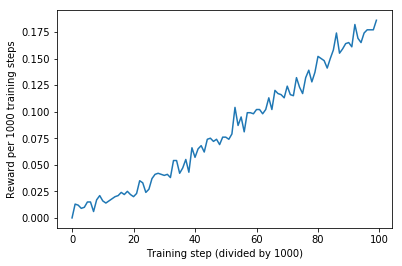

In [50]:
#Step 3: Run MDP training algorithm on the environment from step 1. Observe reward/time curve.
training_steps = 100000
initial_epsilon = 1
epsilon = initial_epsilon 
anneal_epsilon = True #do we decrease epsilon over time?
max_history_length = 10 #how many past actions do we want to encourage?
history = deque([])
progress = progress_bar.ProgressBar(total_elements=training_steps)
reward_trends = []
reward_trend_interval = 1000
cumulative_reward_trend = 0

#This is the main training loop.
for i in range(0, training_steps):
    state, action, reward = train_step(env, mdp, epsilon)
    history.append({"state": state, "action": action})
    while len(history) > max_history_length:
        history.popleft()
        
    if reward > 0:
        for sa in history:
            mdp.encourage(sa["state"], sa["action"])
        cumulative_reward_trend += reward
        
    #We just "turn down" epsilon by a linear interpolation from initial_epsilon to 0.
    if anneal_epsilon:
        epsilon_lerp = initial_epsilon / training_steps
        epsilon = epsilon - epsilon_lerp
        if epsilon < 0:
            epsilon = 0 #might happen due to floating point error stacking up?
            
    if i % reward_trend_interval == 0:
        reward_trends.append(cumulative_reward_trend / reward_trend_interval)
        cumulative_reward_trend = 0
        progress.update(i).draw()
            
progress.update(training_steps).draw()
            
plt.plot(range(len(reward_trends)), reward_trends)
plt.ylabel("Reward per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

In [4]:
#What does the MDP internal state->action pairs look like:
pprint(mdp.state_actions)

{'00000001': {0: 3813, 1: 3613, 2: 51420, 3: 3359},
 '00000010': {0: 2675, 1: 4476, 2: 35930, 3: 2561},
 '00000100': {0: 3418, 1: 51438, 2: 3955, 3: 3604},
 '00001000': {0: 2563, 1: 36156, 2: 2579, 3: 4413},
 '00010000': {0: 3622, 1: 3975, 2: 3419, 3: 51183},
 '00100000': {0: 4354, 1: 2774, 2: 2577, 3: 36259},
 '01000000': {0: 51563, 1: 3563, 2: 3708, 3: 3971},
 '10000000': {0: 36803, 1: 2655, 2: 4394, 3: 2727}}


In [5]:
#Observe our agent after training for a while. Does it appear to have learned anything?
for i in range(0,50):
    train_step(env, mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|        |  
|        |  
|        |  
|   A    |  
|        |  
|        |  
|       R|  
|        |  
----------


Success! What's next?
--------------------------------

Huzzah! Our Markov Decision Process was trained (unless your run was exceptionially unlucky) and can navigate the environment, collecting reward with ease. Where can we go from here?

The logical next step given my goals is to attempt to model the Markov Decision Process with a Neural Network. It would be great if we could just drop in a Neural Network where the MDP was an train it with exactly the same process. Will that work? I'm thinking it should (with some minor tweaks) since neural networks are effectively arbitrary function approximators. Thus, it should be able to learn a simple mapping like the MDP. Let's find out!

In [60]:
#If you do not already have PyTorch, you can download & install it from instructions here:
#https://pytorch.org/get-started/locally/
import torch
import torch.nn as nn
import torch.optim as optim

#This class allows us to quickly and easily build a generic feedforward neural network
#We can make it behave like the MDP by adding the same functions we gave the MDP class
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function = torch.sigmoid, num_layers = 1):
        super(NeuralNet, self).__init__()
        self.activation_function = activation_function
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        if self.num_layers < 1:
            self.num_layers = 1
            print("Zero hidden layers not allowed, defaulted to one.")

        self.layers.append(nn.Linear(self.input_size, self.hidden_size))
        for i in range(0, self.num_layers):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        self.layers.append(nn.Linear(self.hidden_size, self.output_size))
        
    def forward(self, x):
        for layer in self.layers:
            x = self.activation_function(layer(x))
        return x


input_size = len(env.get_state_vector())
hidden_size = input_size * 3
output_size = len(env.agent.get_possible_movement_directions())
neural_mdp = NeuralNet(input_size, hidden_size, output_size, num_layers = 2) #maybe we'll play with the other parameters later

#how many parameters to train?
pytorch_total_params = sum(p.numel() for p in neural_mdp.parameters() if p.requires_grad)
print("Number of trainable parameters in Neural MDP: ", pytorch_total_params)

Number of trainable parameters in Neural MDP:  1516


In [7]:
import random

#Takes an integer "target" in the range [0, num_classes] and returns the one-hot 
#encoding of that target as a tensor of length num_classes where the value at index
#target is 1.0 and all other values are 0.
def one_hot(target, num_classes):
    one_hot = torch.zeros(num_classes, dtype=torch.float32)
    one_hot[target] = 1.0
    return one_hot

#Define the observe->action step functionality we use during training
def train_step_nn(env, neural_net, epsilon=0.5):
    #Observe the environment (get the current state).
    state = torch.tensor(env.get_state_vector(as_string=False), dtype=torch.float32)
    
    #Given the state, choose an action. Either from the network, or randomly according to epsilon.
    action_predicted = neural_net(state) #We need to get an output from the network either way
    num_possible_directions = len(env.agent.get_possible_movement_directions())
    choice = random.random()
    if choice < epsilon:
        action_taken = one_hot(random.randint(0, num_possible_directions-1), num_possible_directions)
    else:
        action_taken = action_predicted #TODO FIXME, this is not one-hot! Tends towards zero! Bad!
        
    env.agent.move(torch.argmax(action_taken).item())
    
    #Determine if we got a reward. 
    reward = 0
    if env.has_agent_food_collision():
        reward = 1
        env.reset_food()
        
    #We clone and detach the action_taken because the criteria (used later) cannot accept a tensor for target
    #Which has required_grad=True. Found this out the hard way.
    return state, action_predicted, action_taken.clone().detach(), reward #This will be used by the outer training loop to encourage rewarding actions

#How does the agent move around prior to training the new NN?
#Clearly not the way we want it to!
#The NN's actions are deterministic, we need to add some randomness like the MDP had for training to work!
for i in range(0,10):
    train_step_nn(env, neural_mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|        |  
|        |  
|        |  
|       A|  
|        |  
|        |  
|       R|  
|        |  
----------


Progress: [####################] 100.0%


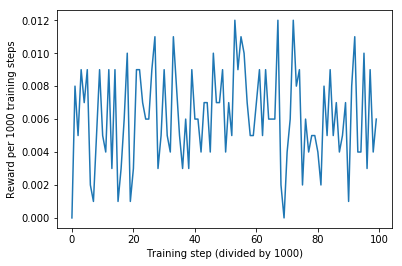

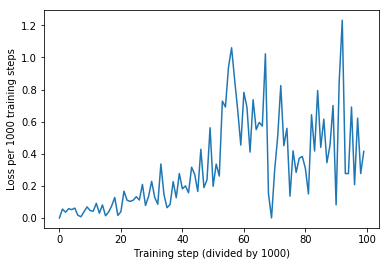

In [61]:
#So let's train the neural network using essentially the same algorithm as before
training_steps = 100000
initial_epsilon = 1
epsilon = initial_epsilon 
anneal_epsilon = False #do we decrease epsilon over time?
max_history_length = 10 #how many past actions do we want to encourage?
history = deque([])
progress = progress_bar.ProgressBar(total_elements=training_steps)
reward_trends = []
loss_trends = []
trend_interval = 1000
cumulative_reward_trend = 0
cumulative_loss_trend = 0

#nn specific setup
criteria = nn.BCELoss()
optimizer = optim.SGD(neural_mdp.parameters(), lr = 0.01, momentum = 0)

#This is the main training loop.
for i in range(0, training_steps):
    state, action_predicted, action_taken, reward = train_step_nn(env, neural_mdp, epsilon)
    history.append({"state": state, "action_predicted": action_predicted, "action_taken": action_taken})
    while len(history) > max_history_length:
        history.popleft()
        
    loss_sum = 0
    if reward > 0: #Only if we got a reward do we backpropogate and adjust any network weights
        for h in history:
            loss_immediate = criteria(h["action_predicted"], h["action_taken"])
            loss_immediate.backward(retain_graph=True)
            loss_sum += loss_immediate
            optimizer.step() #we update weights per step to mimic the MDP training behavior
            
        #loss.backward(retain_graph=True) #Need to retain graph, because we might backprop over these tensors again
        #optimizer.step()
        cumulative_loss_trend += loss_sum.item()
        cumulative_reward_trend += reward
        
    #We just "turn down" epsilon by a linear interpolation from initial_epsilon to 0.
    if anneal_epsilon:
        epsilon_lerp = initial_epsilon / training_steps
        epsilon = epsilon - epsilon_lerp
        if epsilon < 0:
            epsilon = 0 #might happen due to floating point error stacking up?
            
    if i % trend_interval == 0:
        reward_trends.append(cumulative_reward_trend / trend_interval)
        cumulative_reward_trend = 0
        loss_trends.append(cumulative_loss_trend / trend_interval)
        cumulative_loss_trend = 0
        progress.update(i).draw()
            
progress.update(training_steps).draw()
            
plt.plot(range(len(reward_trends)), reward_trends)
plt.ylabel("Reward per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

plt.plot(range(len(loss_trends)), loss_trends)
plt.ylabel("Loss per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

In [9]:
#Observe our agent after training for a while. Does it appear to have learned anything?
for i in range(0,50):
    train_step_nn(env, neural_mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|    A   |  
|        |  
|        |  
|        |  
|        |  
|        |  
|        |  
|     R  |  
----------


Well...
-------

This doesn't appear to be working. At least, it doesn't work using the exact same training methodology. Is there anything we can do to improve this?

In [62]:
#What does the output look like for each possible state? Maybe we (humans) can learn something from it...
    
def print_states_predictions(nnmdp):
    for i in range(0,8):
        inp = one_hot(i, 8)
        output = nnmdp(inp) #get the activation for this state, which is a one-hot vector
        print("In: ", inp, " out: ", output)
        
print_states_predictions(neural_mdp)

In:  tensor([1., 0., 0., 0., 0., 0., 0., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 1., 0., 0., 0., 0., 0., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 1., 0., 0., 0., 0., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 1., 0., 0., 0., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 1., 0., 0., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 1., 0., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 0., 1., 0.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)
In:  tensor([0., 0., 0., 0., 0., 0., 0., 1.])  out:  tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>)


That's quite unusual, each of our states yields the same predicted action! Why is this happening?

What's the last series of actions taken which got a reward?

In [59]:
for i in range(0, len(history)):
    print(history[i])
        
#see output, we're reinforcing the same action a bunch of times!
#maybe it got lucky with the reward appearing in a straight path
#and so we super reinforce that set of actions.

{'state': tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 'action_predicted': tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>), 'action_taken': tensor([0., 1., 0., 0.])}
{'state': tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 'action_predicted': tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>), 'action_taken': tensor([1., 0., 0., 0.])}
{'state': tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 'action_predicted': tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>), 'action_taken': tensor([0., 0., 0., 1.])}
{'state': tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 'action_predicted': tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>), 'action_taken': tensor([0., 1., 0., 0.])}
{'state': tensor([0., 0., 1., 0., 0., 0., 0., 0.]), 'action_predicted': tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>), 'action_taken': tensor([0., 0., 0., 1.])}
{'state': tensor([0., 1., 0., 0., 0., 0., 0., 0.]), 'action_predicted': tensor([0., 0., 0., 0.], grad_fn=<SigmoidBackward>), 'action_taken': tensor([0., 0., 1., 0.])